In [146]:
import pandas as pd 
import sys
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


Dans le cadre de notre projet Ac’Lab Station Météo de fin d'étude et avec l'aide des IOT Maker, nous tenterons de répondre à la question suivante :
Quels facteurs atmosphériques influent sur la présence de pluie ?
Pour ce faire, nous avons à disposition un fichier json avec des données météos qui reflète les données échanger par la station météo. Ce fichier nous permet de pouvoir commencer à travailler en attendant les données des étudiants en Maker qui doivent, de leur coté, développer la partie hardware.

In [147]:

df = pd.read_json('weather.json', lines=True)



In [148]:
df['pressure'].mean()

1005.8576579802061

Pour commencer, voici des informations sur les données que nous utilisons, elles sont extraites du fichier 'weather_station.json'.

In [149]:
df.head

<bound method NDFrame.head of                     _id  humidity                                       date  \
0      04_27_2017_03_08      67.0  {'$date': '2017-04-27T06:08:36.000+0300'}   
1      04_27_2017_03_19      66.0  {'$date': '2017-04-27T06:19:05.000+0300'}   
2      04_27_2017_03_29      66.0  {'$date': '2017-04-27T06:29:34.000+0300'}   
3      04_27_2017_03_40      64.0  {'$date': '2017-04-27T06:40:04.000+0300'}   
4      04_27_2017_03_50      61.0  {'$date': '2017-04-27T06:50:33.000+0300'}   
...                 ...       ...                                        ...   
79224  01_23_2019_01_28      85.0  {'$date': '2019-01-23T03:28:31.000+0200'}   
79225  01_23_2019_01_38      85.0  {'$date': '2019-01-23T03:38:57.000+0200'}   
79226  01_23_2019_01_49      86.0  {'$date': '2019-01-23T03:49:24.000+0200'}   
79227  01_23_2019_01_59      85.0  {'$date': '2019-01-23T03:59:51.000+0200'}   
79228  01_22_2019_11_54       NaN  {'$date': '2019-01-22T13:54:00.000+0200'}   

       pr

Comme on peut le voir, notre premier jeu de données contient 71712 lignes et 9 colonnes. 
Les 9 colonnes correspondent à l'id (id), la date (date), l'humidité (humidity), la pression (pressure), la temperature (temperature), la pluie (rain) et enfin la luminosité (light).

Notre première étape va être d'essayer de connaitre dans quelle unité de mesure sont chaques colonnes.
Tout d'abord, l'humidité est un taux et se calcule donc en pourcentage (%).
La pression est en HectoPascal (hPa), la temperature en degré celsius (°C). Pour la luminosité, après plusieurs recherches, nous pensons qu'elle est en Lumen mais nous ne sommes pas certains.
Enfin, pour mesurer la pluie, on utilise la pluviométrie, ici, elle est calculée en millimétre par heure. 1 mm d'eau correspond à 1 litre par métre carré.
Si il y 25 mm, cela correspond donc à 25 L d'eau par métre carré.

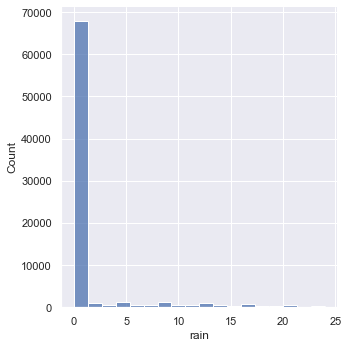

In [150]:
sns.displot(df['rain'])

Avec visualisation, on peut voir la distribution de la variable 'rain'. On peut donc affirmer q'une grande partie de nos données ont pour valeur 0 dans la colonne 'rain'. Ce qui veut dire qu'il ne pleut pas une grande partie du temps.
L'objectif, à présent, est de voir s'il existe des facteurs qui permettent de déterminer si il va pleuvoir ou non.

4698.0

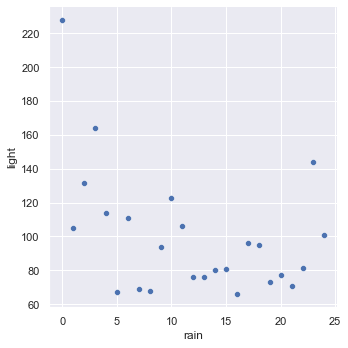

In [151]:
sns.relplot(x="rain",y="light",data= df.groupby('rain').mean())
max(df['light'])

Cette première visualisation nous permet de voir la valeur moyenne de light, selon la valeur de rain
On voit donc que lorsqu'il pleut, la luminosité est plus faible que lorsqu'il ne pleut pas. On peut donc penser qu'il y a une corrélation entre la luminosité et la pluie. Il est donc probable que dans le lieu d'ou proviennent ces données, il y a plus de chances qu'il pleuve le soir ou la nuit

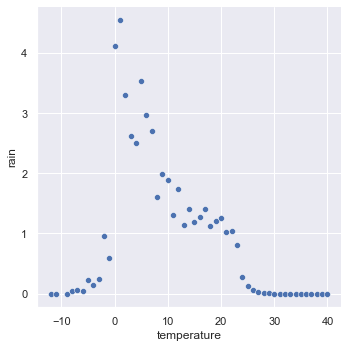

In [152]:
sns.relplot(x="temperature",y="rain",data= df.groupby('temperature').mean())

À présent, grâce à cette visualisation, on peut voir la valeur moyenne de "rain" selon la temperature. 
Tout d'abord, quelque chose est frappant, en effet, lorsque la temperature est inférieure à -5 degrés et supérieur à 25 degrés, en moyenne, il  ne pleut pas.
De plus, la pluie est la plus forte lorsque la temperature est entre 0 et environ 7 degrés.
Il y a donc certainement une corrélation entre la temperature et la pluie, sachant qu'il semble logique qu'il ne puisse pleuvoir à une temperature infèrieure à 0°C car les precipitations se font sous d'autres formes (neige, grêle...).

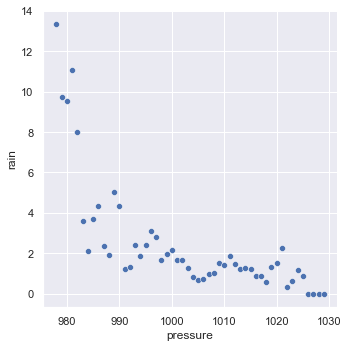

In [153]:
sns.relplot(x="pressure",y="rain",data= df.groupby('pressure').mean())

Avec cette visualisation, on souhaite voir la valeur moyenne de "rain" selon la pression atmosphérique. On peut donc voir que plus la pression est faible, moins il y a de chances qu'il pleuve. Au delà de 1250, il est très peu probable qu'il pleuve. 
Cette constation est confirmée par le site de météo france qui dit "Le plus souvent, le temps est à la pluie lorsque la pression est basse".

In [154]:
df['pressure'].mean()

1005.8576579802061

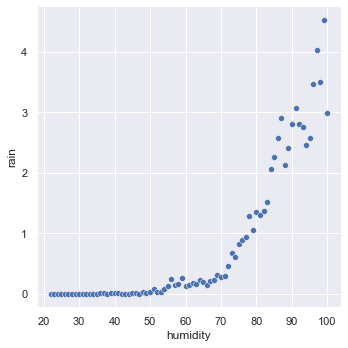

In [155]:
sns.relplot(x="humidity",y="rain",data= df.groupby('humidity').mean())

Ensuite, cette visualisation nous permet de voir la valeur moyenne de rain selon le taux d'humidité, on peut donc voir que plus le taux d'humidité est élevé, plus la valeur moyenne de rain est élevée. Cela parrait plutôt logique mais cette visualisation nous permet de voir que le phénomène est flagrant. 

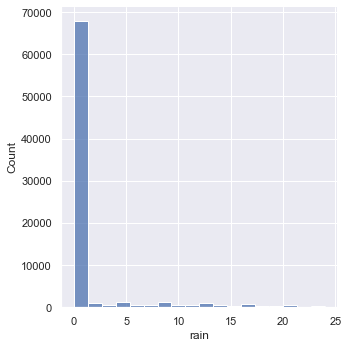

In [156]:
df['rain'].value_counts()
sns.displot(df['rain'])

Cela confirme ce que l'on disait, sur environ 80 000  lignes, plus de 60 000 ont pour valeur 0 dans la colonne rain. Avec cette information, on peut supposer que ces données méteorologiques viennent d'un endroit assez sec. 
Pour répondre à la question que l'on se pose "va t'il pleuvoir dans l'heure ?", certaines informations ne sont pas nécessaires nous allons donc ne garder que certaines colonnes, seulement celles qui nous parraissent utiles pour notre objectif. Nous avons donc choisi de ne pas utiliser la colonne "light". En effet, elle dépend énormement de l'endroit ou est placé la station (ombre ou non) et varie donc selon la position du soleil. De plus, nous voulons supprimer les lignes qui contiennent des colonnes vides.

In [157]:
df = df[['humidity','date','pressure','temperature','rain']]
df = df.dropna()
print(df.isnull().values.any())



False


Nous pouvons donc maintenant séparer nos colonnes en 2 types : Les colonnes 'humidity', 'date', 'pressure', 'temperature' seront nos valeurs de caractéristiques et la colonne 'rain' sera la valeur cible (celle qu'on cherche à prédire).

Pour répondre à notre question, nous avons décidé d'utiliser l'algorithme K-nn, pour ce faire, nous avons besoin que la valeur cible soit une valeur qualitative. Cependant, pour l'instant notre valeur cible est une valeur discrète allant de 0 à 24. Selon meteocontact.fr, moins de 2.5 mm par heure correspond à une pluie faible, une pluie modérée est comprise entre 2.5 mm et 7.5 mm par heure et enfin une pluie forte est supérieure à 7.5 mm par heure.  Nous avons donc fait le choix de créer une nouvelle colonne qui prendra la valeur 'sec' lorsque rain = 0, la valeur 'faible' lorsque rain <= 2.5, si rain <=7.5  et > 2.5, la colonne prend la valeur 'Modéré' et enfin, si rain > 7.5, la colonne prend la valeur 'forte'.


In [158]:

df.loc[df.rain == 0,'rain1']='sec'
df.loc[df.rain > 7.5,'rain1']='forte'
df.loc[(df.rain <= 7.5) & (df.rain > 2.5),'rain1']='pluie modéré'
df.loc[(df.rain <= 2.5) & (df.rain > 0),'rain1']='faible pluie'
x = df[['humidity','pressure','temperature']]
y = df[['rain1']]

Pour utiliser l'algorithme K-nn, nous allons utiliser la bibliothèque Scikit-learn qui est la plus utilisé pour le machine learning.
Nous allons ensuite fractionner notre jeu de données, 80 % pour la phase d'apprentissage et 20 % pour la phase de test.

In [159]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0, test_size=0.30)

Le but maintenant est de déterminer la valeur de k pour laquelle, l'accuracy est la plus haute.

In [160]:
kvalue = pd.DataFrame(columns = ['k','training_score','test_score'])
for k in range (1,11) :
    #instanciation et définition du k
    knn = KNeighborsClassifier(n_neighbors = k)
    #training
    knn.fit(x_train,y_train.values.ravel())
    training_score = knn.score(x_train, y_train)
    test_score = knn.score(x_test, y_test) 
    kvalue = kvalue.append([{'k' : k, 'training_score' : training_score,'test_score' : test_score}])
kvalue = kvalue.set_index('k')
print(kvalue)

    training_score  test_score
k                             
1         0.909661    0.863444
2         0.890359    0.842017
3         0.909004    0.881943
4         0.908884    0.880270
5         0.911096    0.888450
6         0.909482    0.888125
7         0.910179    0.890727
8         0.908327    0.890123
9         0.905697    0.890077
10        0.905876    0.891285


Nous avons donc déterminer le score pour chaque valeur de k entre 0 et 10, le but est d'utiliser la valeur de k pour laquelle le test_score est le plus élevée. 

In [161]:

bestk = kvalue[["test_score"]].idxmax()
knn = KNeighborsClassifier(n_neighbors = bestk[0])
knn.fit(x_train,y_train.values.ravel())
training_score = knn.score(x_train, y_train)
test_score = knn.score(x_test, y_test) 
print(test_score)

0.8912851498954218


La précision de notre algorithme est donc supérieur à 0.88,  ce qui veut dire que plus de 88% de nos données de test ont été prédites correctement.
Nos analyses démontrent que la pression de l'air, la température ambiante et l'humidité influent ou sont influencées par l'apparition de la pluie. Nous avons donc effectuait des recherches à ce sujet, et nous avons constaté que ce sont bel et bien  ces facteurs qui influencent la pluie, et non l'inverse. Cela confirme nos hypothèses à propos des facteurs affectant la pluie.

In [164]:
testpredict = knn.predict(x_test)
aa = 
print(knn.predict([[76,1007,16]]))


['sec']


/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"
